In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import torch
from torch import nn
import torch.nn.functional as F

plt.rcParams["figure.figsize"] = (20, 9)

- Content
- The variables listed below, from left to right, are:
    -   Density determined from underwater weighing
    -   Percent body fat from Siri's (1956) equation
    -   Age (years)
    -   Weight (lbs)
    -   Height (inches)
    -   Neck circumference (cm)
    -   Chest circumference (cm)
    -   Abdomen 2 circumference (cm)
    -   Hip circumference (cm)
    -   Thigh circumference (cm)
    -   Knee circumference (cm)
    -   Ankle circumference (cm)
    -   Biceps (extended) circumference (cm)
    -   Forearm circumference (cm)
    -   Wrist circumference (cm)

In [31]:
dataset_address = "../datasets/kaggle/stroke-prediction/"
filename = "healthcare-dataset-stroke-data.csv"
df = pd.read_csv(dataset_address+filename, sep=",")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Convert values into categories

In [32]:
LE = LabelEncoder()
df["gender"] = LE.fit_transform(df["gender"])                   # Female: 0, Male: 1, Others: 2
df["ever_married"] = LE.fit_transform(df["ever_married"])       # No: 0, Yes: 1
df["work_type"] = LE.fit_transform(df["work_type"])             # Govt_job:0, Never_worked: 1, Private: 2, Self-employed: 3, children: 4
df["Residence_type"] = LE.fit_transform(df["Residence_type"])   # Rural: 0, Urban: 1
df["smoking_status"] = LE.fit_transform(df["smoking_status"])   # Unknown: 0, formerly smoked: 1, never smoked: 2, smokes: 3
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,51676,0,61.0,0,0,1,3,0,202.21,NaN,2,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,2,1


In [33]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

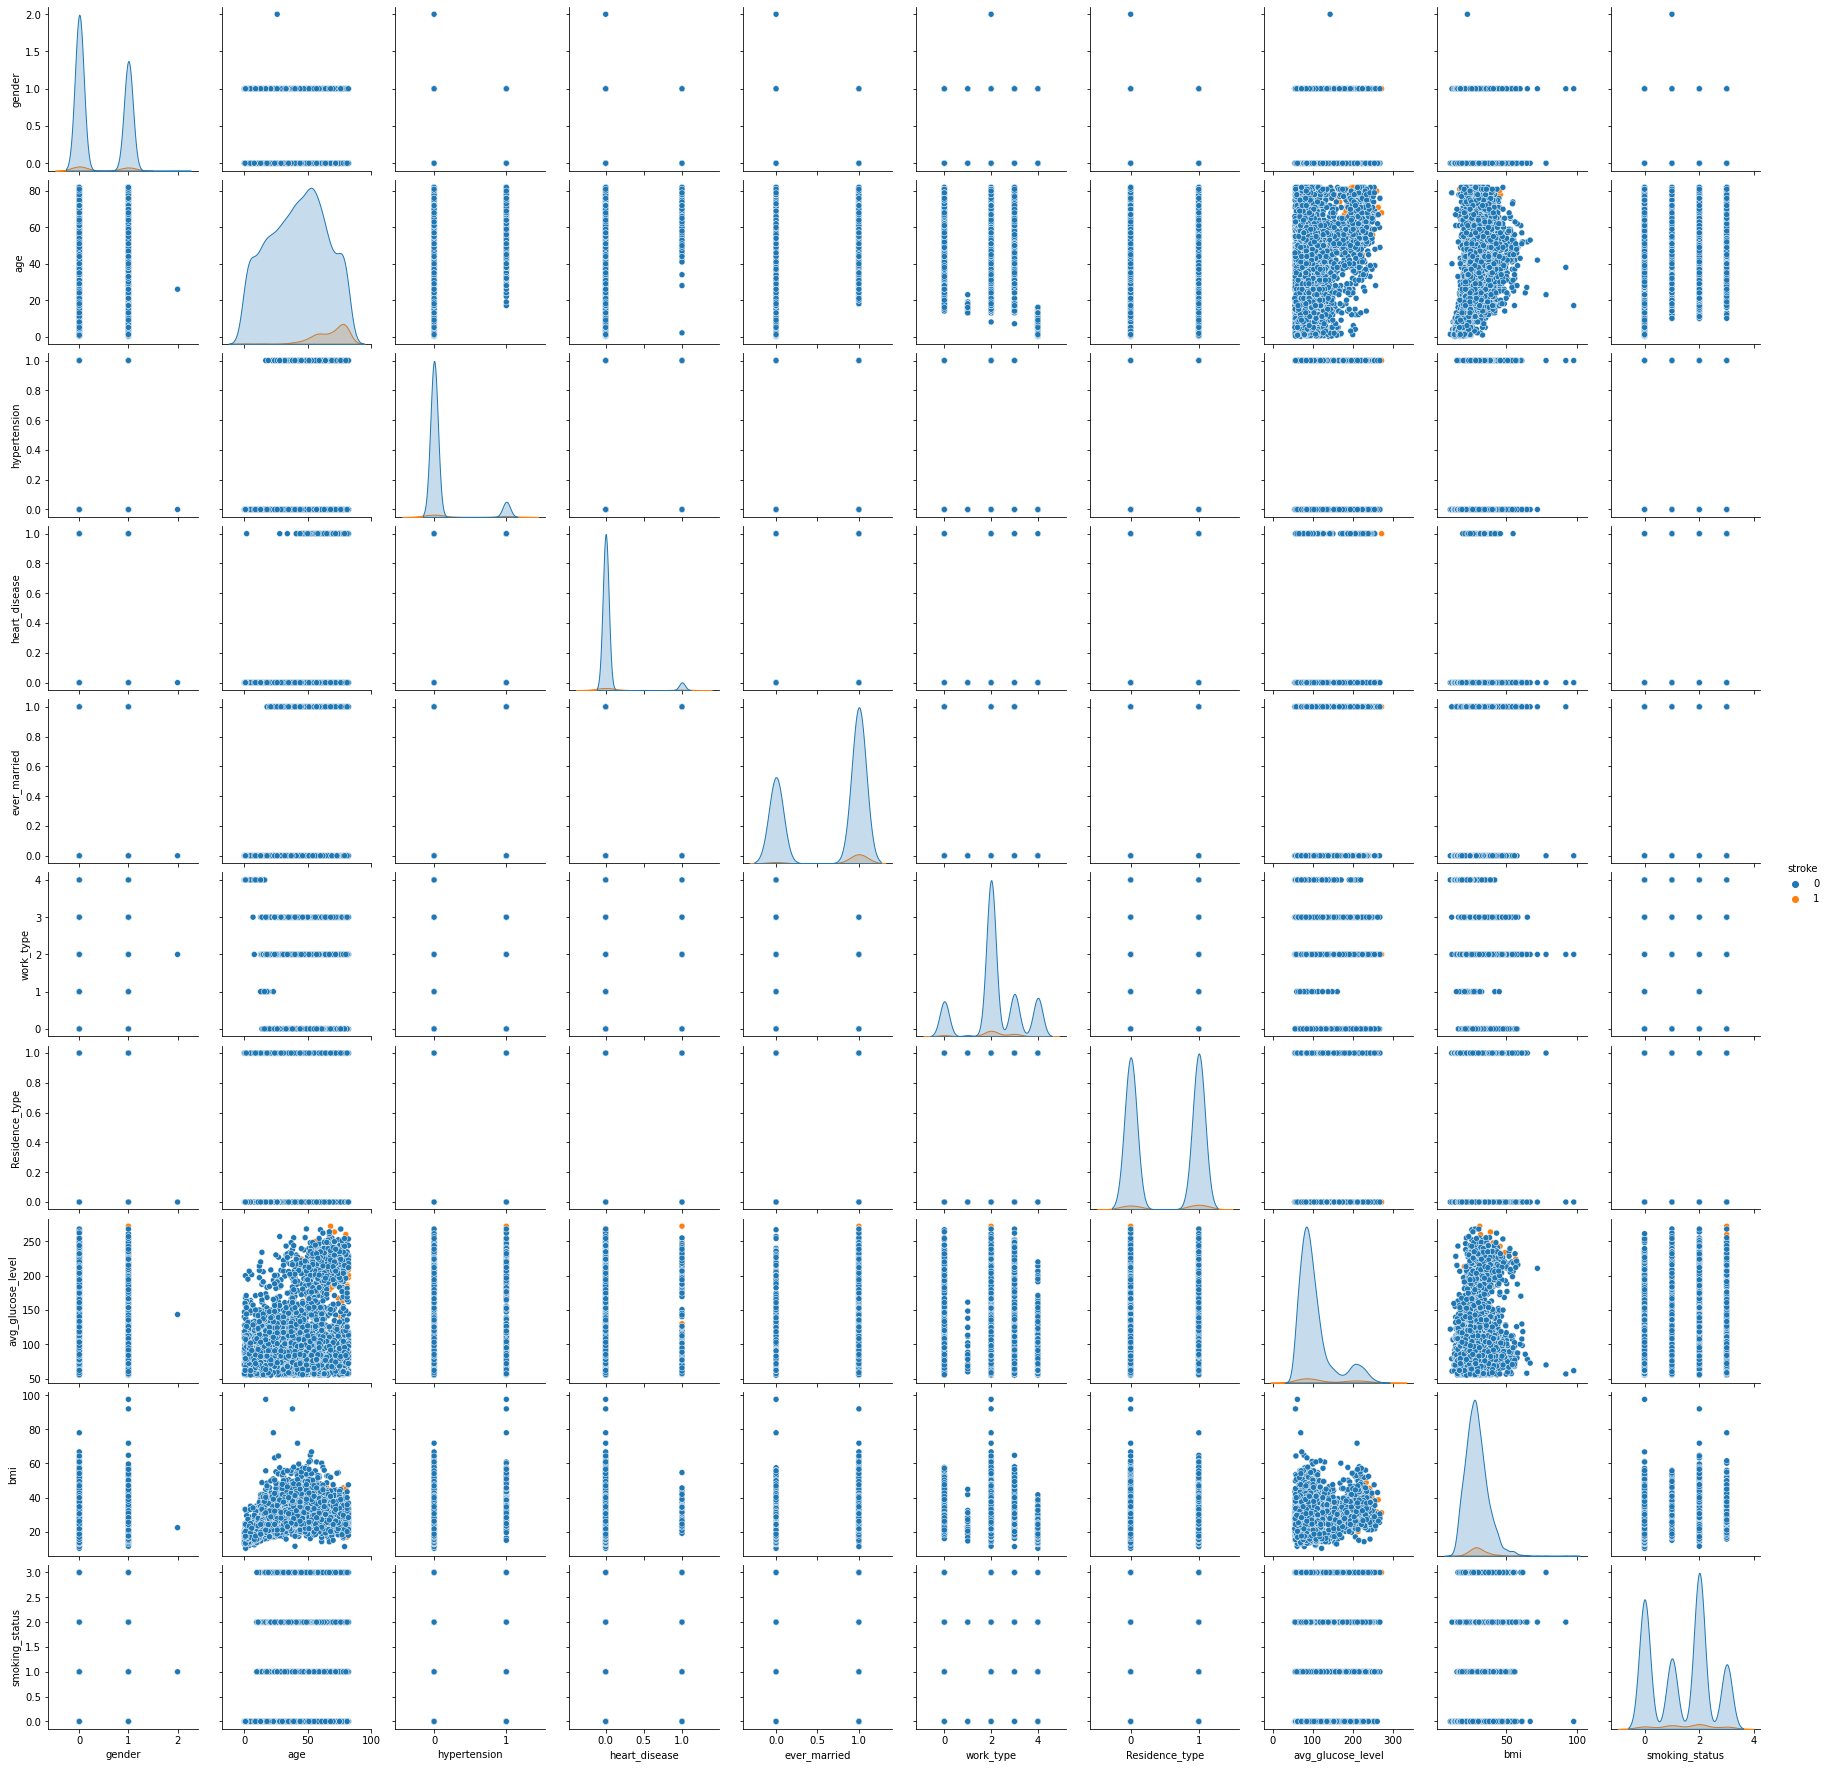

In [34]:
cols = df.columns[1: 11].to_list() 
sns.pairplot(df.loc[:, cols+["stroke"]], hue="stroke")
plt.show();

In [35]:
cols_X = ["gender", "age", "bmi"]
cols_y = ["stroke"]
data_X = df.loc[:, cols_X].values
data_X = MinMaxScaler().fit_transform(data_X)
data_y = df.loc[:, cols_y].values.flatten()

In [479]:
# specify sizes of the partitions
# order is train, dev, test
partitions = [.75, .10, .15]

# split the data (note the third input, and the TMP in the variable name)
train_data, testdev_data, train_labels, testdev_label = train_test_split(data_X, data_y, train_size=partitions[0])

# now split the testdev_data
split = partitions[1] / np.sum(partitions[1:])
dev_data, test_data, dev_labels, test_labels = train_test_split(testdev_data, testdev_label, train_size=split)

In [480]:
def create_model(n_input=1, n_output=1, lr=.01):
    model = nn.Sequential(
        nn.Linear(n_input, n_input*10),
        nn.ReLU(),
        nn.Linear(n_input*10, n_input*20),
        nn.ReLU(),
        nn.Linear(n_input*20, n_input*10),
        nn.ReLU(),
        nn.Linear(n_input*10, n_output),
        # nn.Softmax(dim=1),
    )

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    return model, optimizer

def train_model(X, y, X_dev, y_dev, model=None, loss_func=nn.CrossEntropyLoss(), optimizer=None, n_epochs=1, plot_history=False):
    X = torch.Tensor(X).float()
    y = torch.Tensor(y).long()
    X_dev = torch.Tensor(X_dev).float()
    y_dev = torch.Tensor(y_dev).long()
    
    losses = torch.zeros(n_epochs)
    accs = torch.zeros(n_epochs)
    losses_dev = torch.zeros(n_epochs)
    accs_dev = torch.zeros(n_epochs)

    ## Train the model!
    for i in range(n_epochs):

        # forward pass
        preds = model(X)
        # compute loss (trainset)
        loss = loss_func(preds, y)
        losses[i] = loss
        
        # forward pass
        preds_dev = model(X_dev)
        # compute loss (dev)
        loss_dev = loss_func(preds_dev, y_dev)
        losses_dev[i] = loss_dev
        
        # compute accuracy (trainset)
        acc = 100*torch.mean((torch.argmax(preds, axis=1) == y).float()) 
        accs[i] = acc
        
        # compute accuracy (dev)
        acc_dev = 100*torch.mean((torch.argmax(preds_dev, axis=1) == y_dev).float()) 
        accs_dev[i] = acc_dev
        
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # final forward pass (trainset)
    predictions = model(X)
    total_acc = 100*torch.mean((torch.argmax(predictions, axis=1) == y).float())
    
    # final forward pass (dev)
    predictions_dev = model(X_dev)
    total_acc_dev = 100*torch.mean((torch.argmax(predictions_dev, axis=1) == y_dev).float())

    if plot_history:
        _, axes = plt.subplots(1, 2)

        axes[0].plot(losses.detach(), label="Loss (trainset)")
        axes[0].plot(losses_dev.detach(), label="Loss (dev)")
        axes[0].set_ylabel("Loss")
        axes[0].set_xlabel("Epochs")
        axes[0].set_title(f"Final Loss (trainset): {loss.detach():.4f}\nFinal Loss (dev): {loss_dev.detach():.4f}")
        axes[0].legend()

        axes[1].plot(accs.detach(), label="Accuracy (trainset)")
        axes[1].plot(accs_dev.detach(), label="Accuracy (dev)")
        axes[1].set_ylabel("Accuracy")
        axes[1].set_xlabel("Epochs")
        axes[1].set_title(f"Final Accuracy (trainset): {total_acc.detach():.2f} %\nTotal Accuracy (dev): {total_acc_dev.detach():.2f} %")
        axes[1].legend()
        
        plt.show()
    return accs, losses, accs_dev, losses_dev

def evaluate_model(X, y, model, loss_func=nn.CrossEntropyLoss(), label_names=["X1", "X2"]):
    X = torch.Tensor(X).float()
    y = torch.Tensor(y).long()

    # manually compute losses
    # final forward pass
    predictions = model(X)
    
    # compute Loss
    loss = loss_func(predictions, y)
    # compute accuracy
    acc = 100*torch.mean((torch.argmax(predictions, axis=1) == y).float())
    
    softmax = nn.Softmax(dim=1)    
    plt.plot(softmax(predictions.detach()), "o")                # with Softmax activation
    # plt.plot(predictions.detach(), "s-", markerfacecolor="w") # without Softmax activation
    plt.xlabel("Stimulus number")
    plt.ylabel("Probability")
    plt.legend(label_names)
    plt.title(f"Accuracy (testset): {acc.detach():.2f} %\nLoss (testset): {loss.detach():.4f}")
    plt.show()

    return acc, loss, predictions

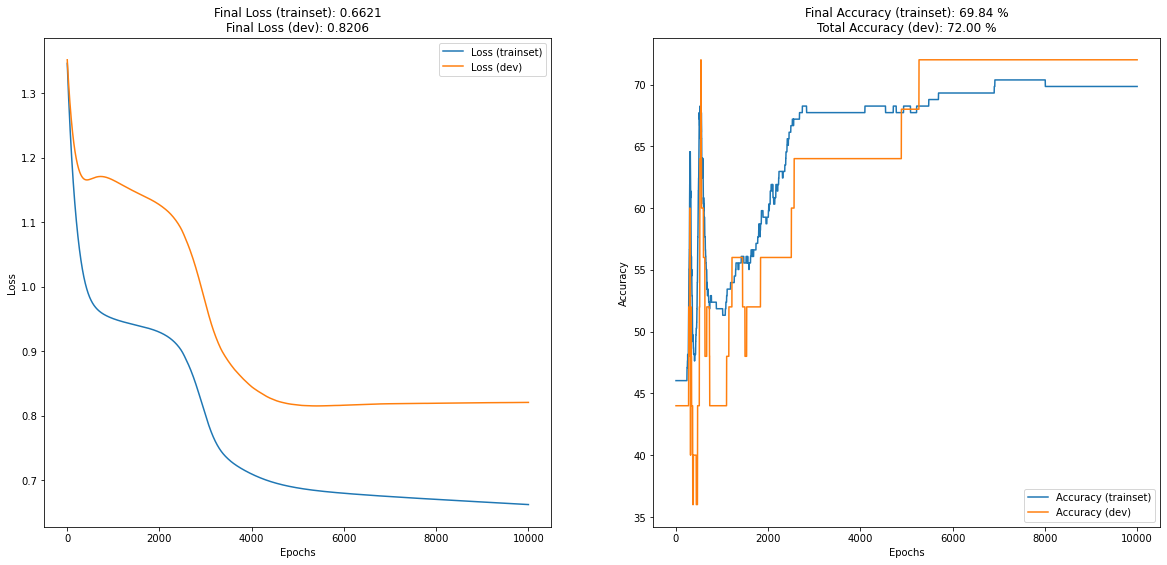

In [481]:
model, optimizer = create_model(n_input=len(cols_X), n_output=len(np.unique(data_y)), lr=.01)
history = train_model(
    X=train_data, y=train_labels, X_dev=dev_data, y_dev=dev_labels,
    model=model, loss_func=nn.CrossEntropyLoss(), optimizer=optimizer, n_epochs=10000,
    plot_history=True
)

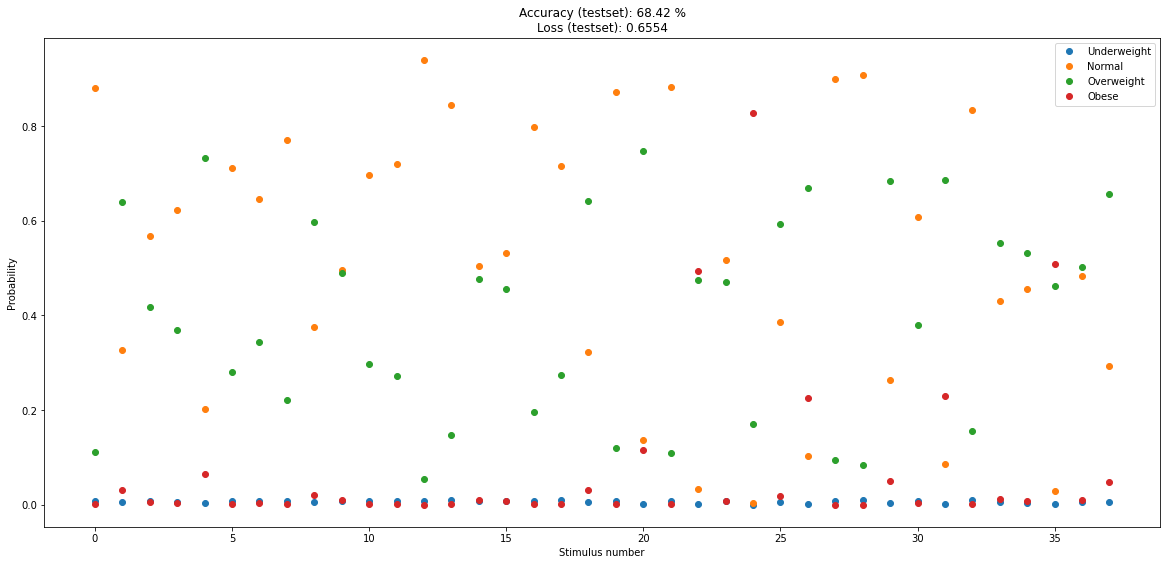

Test Accuracy: 68.42%
Test Loss: 0.6554


In [482]:
acc, loss, pred = evaluate_model(X=test_data, y=test_labels, model=model, label_names=["Underweight", "Normal", "Overweight", "Obese"])
print(f"Test Accuracy: {acc:.2f}%")
print(f"Test Loss: {loss:.4f}")